Now for a little SQL. The database I have chosen to work with is a kaggle dataset located at https://www.kaggle.com/datasets/usdeptofag/pesticide-data-program-2013 . The sqlite database contains the info on samples of various agricultural products and the tests performed on them to ensure that any pesticides present in the finished product are below acceptable levels. Much of the data in these tables is in the form of codes which reference various csv tables. I have also downloaded those csv tables which are most pertinent to the question I have chosen to ask. That question is from which countries most of the contaminated products originate. 

First, our imports, then lets do a little bit of exploration to figure out what our tables look like. 

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
#The next line lets us have some wider columns, which will be needed.
pd.set_option('max_colwidth', 600)

connection = sqlite3.connect("database.sqlite")
sql_query = """SELECT name FROM sqlite_master 
WHERE type='table';"""
cursor = connection.cursor()
cursor.execute(sql_query)
print("List of tables")
print(cursor.fetchall())

data=cursor.execute('''SELECT * from sampledata13''')
print()
print("List of columns in sampledata13")
for column in data.description:
    print(column[0])
print()
data=cursor.execute('''SELECT * from resultsdata13''')
print()
print("List of columns in resultsdata13\n")
for column in data.description:
    print(column[0])
#Now we know what our tables look like, let's check some data rows for each.
cursor.execute("""Select * from sampledata13""")
print()
print("Sample data row")
print(cursor.fetchone())

cursor.execute("""Select * from resultsdata13""")
print()
print("Results data row")
print(cursor.fetchone())


List of tables
[('sampledata13',), ('resultsdata13',)]

List of columns in sampledata13
sample_pk
state
year
month
day
site
commod
source_id
variety
origin
country
disttype
commtype
claim
quantity
growst
packst
distst


List of columns in resultsdata13

sample_pk
commod
commtype
lab
pestcode
testclass
concen
lod
conunit
confmethod
confmethod2
annotate
quantitate
mean
extract
determin

Sample data row
(1, 'CA', '13', '01', '22', '0004', 'AJ', 'P', 'Apple Juice', '2', '150', 'R', 'RE', 'PO', '', '', '', 'IL\r\n')

Results data row
(1, 'AJ', 'RE', 'WA1', '540', 'A', '', 0.002, 'M', '', '', '', '', 'ND', '805', '35\r\n')


So now we know what our tables look like and we have an idea what our rows of data in each table will look at. It becomes immediately apparent that we are going to need some help to interpret this data. This is where the included csv files come in. The first one, anotate_codes.csv is the one that refers to column which represents the test results in the results data table. I have displayed it below.

In [2]:
andf = pd.read_csv('anotate_codes.csv')
andf


Looking at this table, we know that we are only interested in rows where the annotate code is not blank or equal to Q, since those are the rows where we have enough pesticide contaminating the item to be of concern. We now have a pretty good idea of what we want to pull from the database. Since there are a large number of columns and rows we are not presently interested in, let's start with simplifying matters by creating a view of what we do want to see.

In [3]:
cursor.execute('CREATE VIEW sample_results AS SELECT sample_pk, annotate FROM resultsdata13 WHERE not annotate="" and not annotate="Q"')

In [4]:
cursor.execute('select * from sample_results')
#Printing one line to make sure our view looks right.
print(cursor.fetchone())

(1183, 'V')


We have trimmed down our sample data table down to what we want to see, so now we pull the data from the results data table to get our answers.

In [5]:
a = 'SELECT sample_results.sample_pk, sample_results.annotate, sampledata13.country, sampledata13.origin from sample_results left join sampledata13 on sample_results.sample_pk = sampledata13.sample_pk'
df = pd.read_sql(a, connection)
df

,sample_pk,annotate,country,origin
0,1183,V,,1
1,1196,V,,1
2,1230,V,,1
3,1269,V,595,2
4,1269,V,595,2
...,...,...,...,...
349,9794,QV,595,2
350,9828,QV,595,2
351,9856,V,595,2
352,9856,V,595,2


We can see right away that we have quite a few rows where the country column is blank. A quick look at another one of the csvs will provide us with an explanation though.

In [6]:
odf = pd.read_csv('origin_codes.csv')
odf

,Origin Code,Origin of Sample
0,1,Domestic (U.S.)
1,2,Imported
2,3,Unknown origin


This tells us that if our origin code is a 1, the country is the USA. Any item with an unknown origin is useless to us, since origin is what we're looking at. Therefore, we should drop any rows where the origin code is 3. We also need to put something inside the country column where it's empty.

In [7]:
df = df[df['origin'] != 3]
df

def insert_usa(string):
    if string =='':
        string = '1'
    else:
        string = string
    return string
df['country'] = df['country'].apply(insert_usa)
df

,sample_pk,annotate,country,origin
0,1183,V,1,1
1,1196,V,1,1
2,1230,V,1,1
3,1269,V,595,2
4,1269,V,595,2
...,...,...,...,...
349,9794,QV,595,2
350,9828,QV,595,2
351,9856,V,595,2
352,9856,V,595,2


Now we put our last csv file to use. This is the file that translates country codes to actual countries.

In [8]:
cdf = pd.read_csv('country_codes.csv')
cdf.reset_index(inplace=True)
cdf.set_index('Country Code', inplace=True)
del cdf['index']
x = cdf.to_dict()
x = x['Country Name']
x['1'] = 'USA'
df['country'] = df['country'].map(x)
df

,sample_pk,annotate,country,origin
0,1183,V,USA,1
1,1196,V,USA,1
2,1230,V,USA,1
3,1269,V,Mexico,2
4,1269,V,Mexico,2
...,...,...,...,...
349,9794,QV,Mexico,2
350,9828,QV,Mexico,2
351,9856,V,Mexico,2
352,9856,V,Mexico,2


Now, we just need to look at the numbers per country.

<AxesSubplot:xlabel='country', ylabel='count'>

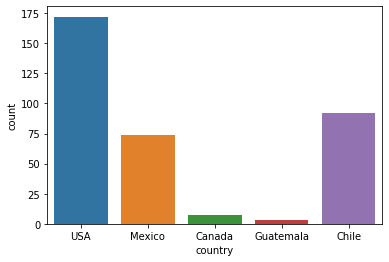

In [9]:
sns.countplot(x='country',data=df)

In [10]:
bycountry = df.groupby('country').count()
bycountry


,sample_pk,annotate,origin
country,,,
Canada,7,7,7
Chile,92,92,92
Guatemala,3,3,3
Mexico,74,74,74
USA,172,172,172


The USA is clearly the country from which the most contaminated samples originated. However, given that these studies were performed in the US, it seems quite likely that largest number of samples also came from the US. Let's look into that.

In [11]:
a = 'SELECT resultsdata13.sample_pk, sampledata13.country from resultsdata13 left join sampledata13 on resultsdata13.sample_pk = sampledata13.sample_pk'
fdf = pd.read_sql(a, connection)
fdf
fdf['country'] = fdf['country'].apply(insert_usa)
fdf
fdf['country'] = fdf['country'].map(x)
fdf
sfdf = fdf.groupby('country').count()
sfdf

,sample_pk
country,
Argentina,5914
Argentina / Brazil,214
Argentina / Chile / USA,215
Argentina / Mexico / USA,1306
Argentina / USA,2345
Canada,29578
Canada / USA,4845
Chile,149899
China,24656


We can clearly see that the US has by far the greatest number of tests performed on samples. So it would probably be more useful to look at the percentage of tests performed per country that showed a contaminated sample.

In [12]:
country_list = ['USA', 'Canada', 'Chile', 'Mexico', 'Guatemala']
sfdf.reset_index(inplace=True)

In [16]:
sfdf

,country,sample_pk
0,Argentina,5914
1,Argentina / Brazil,214
2,Argentina / Chile / USA,215
3,Argentina / Mexico / USA,1306
4,Argentina / USA,2345
5,Canada,29578
6,Canada / USA,4845
7,Chile,149899
8,China,24656
9,China / Russia,709


In [30]:
needed = pd.DataFrame()
for item in country_list:
    needed = pd.concat([needed, sfdf[sfdf['country'] == item]])
needed.set_index('country', inplace=True)
needed['total_sample_number'] = needed['sample_pk']
needed = needed['total_sample_number']
needed

country
USA          1409715
Canada         29578
Chile         149899
Mexico        200194
Guatemala      48878
Name: total_sample_number, dtype: int64

In [31]:
final = pd.concat([needed, bycountry], axis=1)
final

,total_sample_number,sample_pk,annotate,origin
country,,,,
USA,1409715,172,172,172
Canada,29578,7,7,7
Chile,149899,92,92,92
Mexico,200194,74,74,74
Guatemala,48878,3,3,3


In [33]:
final['contaminated items %'] = final['sample_pk'] / final['total_sample_number']

,total_sample_number,sample_pk,annotate,origin,contaminated items %
country,,,,,
USA,1409715,172,172,172,0.000122
Canada,29578,7,7,7,0.000237
Chile,149899,92,92,92,0.000614
Mexico,200194,74,74,74,0.000370
Guatemala,48878,3,3,3,0.000061


In [34]:
cursor.close()
connection.close()

So now we can see that while the USA has the highest number of tests which showed a product contaminated by a pesticide, that is clearly influenced by the high number of samples taken from the USA. Of all the countries whose products were tested and showed contamination, Chile is worst, with 0.06% and the USA is the second best (losing out to Guatemala) with only a 0.01% of tests performed on products that showed significant pesticide contamination.